In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# printing the table names in sql database
print(engine.table_names())

['measurement', 'station']


C:\Users\61469\AppData\Local\Temp\ipykernel_30296\24082839.py:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
# -- already done in line 5

In [8]:
# Save references to each table
# making variables for base calls
# for measurment table,
measure = Base.classes.measurement
#for station 
station = Base.classes.station

In [22]:
measure.__dict__.keys()


dict_keys(['__table__', '__module__', '__doc__', '_sa_class_manager', '__init__', 'id', 'station', 'date', 'prcp', 'tobs', '__mapper__'])

In [23]:
station.__dict__.keys()

dict_keys(['__table__', '__module__', '__doc__', '_sa_class_manager', '__init__', 'id', 'station', 'name', 'latitude', 'longitude', 'elevation', '__mapper__'])

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(measure.date).order_by(measure.date.desc()).first()[0]
recent_date

'2017-08-23'

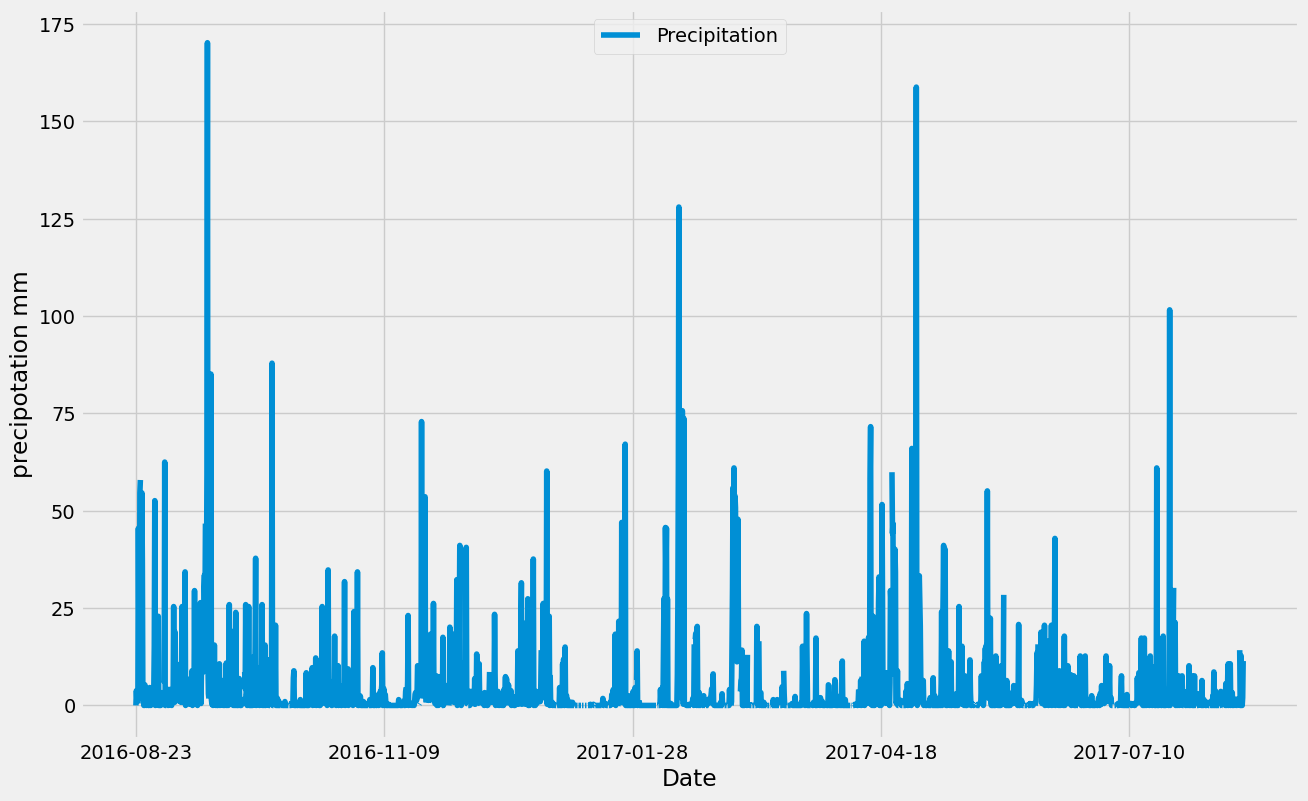

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_before = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recent_precipitation = session.query(measure.date, measure.prcp).filter(measure.date >= year_before).order_by(measure.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(recent_precipitation, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)
# Sort the dataframe by date
prcp_df.sort_index() 
prcp_df
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(14,9))
plt.xlabel('Date')
plt.ylabel('precipotation mm')
plt.legend(loc='upper center')
plt.show()



In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe(include='all')

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(func.count(station.station)).scalar()
total_station

9

In [43]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = (session.query(measure.station, func.count(measure.station)).group_by(measure.station)\
                  .order_by(func.count(measure.station).desc()).all())
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# most active station
most_active = active_station[0][0]
most_active

'USC00519281'

In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temp = (session.query(func.min(measure.tobs), func.max(measure.tobs), func.avg(measure.tobs)).filter(measure.station == most_active).all())
low_temp, high_temp, avg_temp = active_station_temp[0]
print(f'Station {most_active} has {round(low_temp,2)} temperature recorded')
print(f'Station {most_active} has {round(high_temp,2)} temperature recorded')
print(f'Station {most_active} the average {round(low_temp,2)} temperature recorded')

Station USC00519281 has 12.2 temperature recorded
Station USC00519281 has 29.4 temperature recorded
Station USC00519281 the average 12.2 temperature recorded


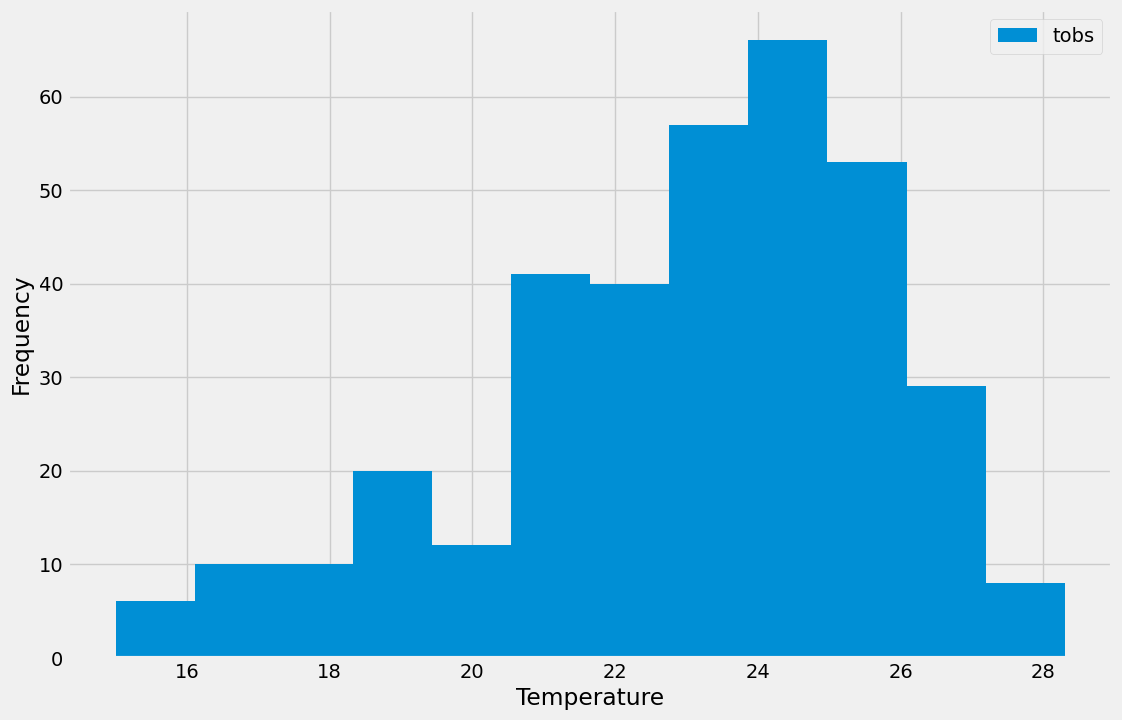

In [68]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_12 = (session.query(measure.tobs).filter(measure.station == most_active).filter(measure.date >= year_before).all())
#type(active_station_12)
active_station_12 = [temp[0] for temp in active_station_12]
type(active_station_12)
plt.figure(figsize=(12,8))
plt.hist(active_station_12, bins=12, label = "tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [69]:
# Close Session
session.close()